# IA for HumanForYou

## Context

L'entreprise de produits pharmaceutiques HumanForYou basée en Inde emploie environ 4000 personnes. Cependant, chaque année elle subit un turn-over d'environ 15% de ses employés nécessitant de retrouver des profils similaires sur le marché de l'emploi.

La direction trouve que ce niveau de turn-over n'est pas bon pour l'entreprise car :

Les projets sur lesquels étaient les employés quittant la société prennent du retard ce qui nuit à la réputation de l'entreprise auprès de ses clients et partenaires.

Un service de ressources humaines de taille conséquente doit être conservé car il faut avoir les moyens de trouver les nouvelles recrues.

Du temps est perdu à l'arrivée des nouveaux employés car ils doivent très souvent être formés et ont besoin de temps pour devenir pleinement opérationnels dans leur nouvel environnement.

Le direction fait donc appel à vous, spécialistes de l'analyse de données, pour déterminer les facteurs ayant le plus d'influence sur ce taux de turn-over et lui proposer des modèles afin d'avoir des pistes d'amélioration pour donner à leurs employés l'envie de rester.

Données fournies
Un certain nombre de données concernant les employés vous a donc été transmis par le service des ressources humaines.

Il s'agit de fichiers textes au format CSV.

Les données ont été anonymisées : un employé de l'entreprise sera représenté par le même EmployeeID dans l'ensemble des fichiers qui suivent.


# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from six.moves import urllib
from zipfile import ZipFile
import math
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

## Import des données

On va importer toutes les données dans des tableau

In [3]:
DOWNLOAD_ROOT = "https://github.com/Teerath67/Projet-IA/raw/master/data.zip"
DATA_PATH = os.path.join("datasets", "data")

MANAGER_SURVEY_CSV = "manager_survey_data.csv"
EMPLOYEE_SURVEY_CSV = "employee_survey_data.csv"
GENERAL_CSV = "general_data.csv"
IN_TIME_CSV = "in_time.csv"
OUT_TIME_CSV = "out_time.csv"

def fetch_data(download_url=DOWNLOAD_ROOT, data_path=DATA_PATH):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    zip_path = os.path.join(data_path, "data.zip")
    urllib.request.urlretrieve(download_url, zip_path)
    data_zip = ZipFile(zip_path, 'r')
    data_zip.extractall(path=data_path)
    data_zip.close()

def load_data(general_path, csv):
    csv_path = os.path.join(general_path, csv)
    df = pd.read_csv(csv_path, sep=",", header = 0)
    return df

fetch_data()

In [4]:
general = load_data(DATA_PATH, GENERAL_CSV)
in_time = load_data(DATA_PATH, IN_TIME_CSV)
out_time = load_data(DATA_PATH, OUT_TIME_CSV)
manager_survey = load_data(DATA_PATH, MANAGER_SURVEY_CSV)
employee_survey = load_data(DATA_PATH, EMPLOYEE_SURVEY_CSV)

## Check des données
On va regarder les prmières lignes des données

In [5]:
general.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


In [6]:
in_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


In [7]:
out_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,NaN,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,NaN,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14


In [8]:
manager_survey.head()

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


## Merge des données en un seul tableau

In [9]:
merged_data = general.merge(manager_survey, how='left', on='EmployeeID')

In [10]:
merged_data.value_counts("JobRole")

JobRole
Sales Executive              978
Research Scientist           876
Laboratory Technician        777
Manufacturing Director       435
Healthcare Representative    393
Manager                      306
Sales Representative         249
Research Director            240
Human Resources              156
dtype: int64

In [11]:
def rename_head(df, header):
    for i, col in enumerate(df.columns):
        df.rename({col: header[i]}, axis=1, inplace=True)
    return df

In [12]:
header_in = in_time.columns.to_list()
header_out = out_time.columns.to_list()

In [13]:
header_in[0] = 'EmployeeID'
header_out[0] = 'EmployeeID'

In [14]:
rename_head(in_time, header_in)

,EmployeeID,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,4406,NaN,2015-01-02 09:20:32,2015-01-05 10:17:53,2015-01-06 10:26:51,2015-01-07 10:06:58,2015-01-08 09:45:06,2015-01-09 09:49:24,2015-01-12 09:37:10,2015-01-13 09:25:02,...,2015-12-18 10:01:06,2015-12-21 10:25:25,2015-12-22 10:16:11,2015-12-23 10:04:40,2015-12-24 09:45:40,NaN,2015-12-28 10:15:39,2015-12-29 10:10:09,2015-12-30 09:28:19,2015-12-31 10:00:12
4406,4407,NaN,2015-01-02 10:03:41,NaN,2015-01-06 09:44:00,2015-01-07 09:42:10,2015-01-08 10:00:57,2015-01-09 09:44:04,2015-01-12 10:07:32,2015-01-13 10:05:11,...,2015-12-18 09:27:32,2015-12-21 09:41:24,2015-12-22 09:50:30,2015-12-23 10:32:21,2015-12-24 09:47:41,NaN,2015-12-28 09:54:23,2015-12-29 10:13:32,2015-12-30 10:21:09,2015-12-31 10:09:48
4407,4408,NaN,2015-01-02 10:01:01,2015-01-05 09:33:00,2015-01-06 09:49:17,2015-01-07 10:28:12,2015-01-08 09:47:38,2015-01-09 10:01:03,2015-01-12 09:49:12,2015-01-13 09:47:10,...,2015-12-18 10:00:57,2015-12-21 09:51:07,2015-12-22 10:02:10,2015-12-23 09:58:29,2015-12-24 09:56:05,NaN,2015-12-28 09:59:24,NaN,2015-12-30 10:02:36,2015-12-31 10:03:30
4408,4409,NaN,2015-01-02 10:17:05,2015-01-05 10:02:27,2015-01-06 10:12:50,2015-01-07 10:12:31,2015-01-08 09:42:57,NaN,2015-01-12 10:00:38,2015-01-13 09:48:03,...,2015-12-18 09:54:33,2015-12-21 10:01:08,2015-12-22 10:10:19,2015-12-23 09:42:30,2015-12-24 09:56:05,NaN,2015-12-28 09:55:25,2015-12-29 09:54:42,2015-12-30 10:15:44,2015-12-31 09:56:47


In [15]:
rename_head(out_time, header_out)

,EmployeeID,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,NaN,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,NaN,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,4406,NaN,2015-01-02 17:27:37,2015-01-05 19:08:20,2015-01-06 18:50:49,2015-01-07 18:57:40,2015-01-08 17:58:31,2015-01-09 18:06:15,2015-01-12 17:58:48,2015-01-13 18:10:35,...,2015-12-18 18:06:05,2015-12-21 18:35:06,2015-12-22 18:33:44,2015-12-23 18:40:56,2015-12-24 18:21:29,NaN,2015-12-28 18:44:35,2015-12-29 19:14:38,2015-12-30 18:24:56,2015-12-31 18:30:41
4406,4407,NaN,2015-01-02 16:19:01,NaN,2015-01-06 15:07:37,2015-01-07 15:25:50,2015-01-08 16:12:33,2015-01-09 15:26:56,2015-01-12 16:10:42,2015-01-13 16:22:43,...,2015-12-18 15:23:02,2015-12-21 15:31:14,2015-12-22 15:45:59,2015-12-23 16:38:59,2015-12-24 15:47:15,NaN,2015-12-28 15:34:34,2015-12-29 16:47:02,2015-12-30 16:03:17,2015-12-31 16:18:39
4407,4408,NaN,2015-01-02 17:17:35,2015-01-05 17:08:07,2015-01-06 17:27:46,2015-01-07 18:27:22,2015-01-08 17:05:25,2015-01-09 17:02:57,2015-01-12 17:35:45,2015-01-13 17:15:52,...,2015-12-18 17:48:05,2015-12-21 17:43:05,2015-12-22 17:47:23,2015-12-23 17:43:37,2015-12-24 17:20:12,NaN,2015-12-28 17:43:28,NaN,2015-12-30 17:48:14,2015-12-31 18:08:55
4408,4409,NaN,2015-01-02 19:48:37,2015-01-05 19:37:40,2015-01-06 20:00:08,2015-01-07 19:35:59,2015-01-08 18:55:13,NaN,2015-01-12 19:18:17,2015-01-13 19:24:02,...,2015-12-18 19:52:44,2015-12-21 19:21:35,2015-12-22 19:32:40,2015-12-23 18:57:00,2015-12-24 19:37:57,NaN,2015-12-28 19:58:36,2015-12-29 18:55:26,2015-12-30 19:37:22,2015-12-31 19:33:45


In [16]:
time_frame = in_time.merge(out_time, how='left', on='EmployeeID')

In [17]:
time_frame

,EmployeeID,2015-01-01_x,2015-01-02_x,2015-01-05_x,2015-01-06_x,2015-01-07_x,2015-01-08_x,2015-01-09_x,2015-01-12_x,2015-01-13_x,...,2015-12-18_y,2015-12-21_y,2015-12-22_y,2015-12-23_y,2015-12-24_y,2015-12-25_y,2015-12-28_y,2015-12-29_y,2015-12-30_y,2015-12-31_y
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,4406,NaN,2015-01-02 09:20:32,2015-01-05 10:17:53,2015-01-06 10:26:51,2015-01-07 10:06:58,2015-01-08 09:45:06,2015-01-09 09:49:24,2015-01-12 09:37:10,2015-01-13 09:25:02,...,2015-12-18 18:06:05,2015-12-21 18:35:06,2015-12-22 18:33:44,2015-12-23 18:40:56,2015-12-24 18:21:29,NaN,2015-12-28 18:44:35,2015-12-29 19:14:38,2015-12-30 18:24:56,2015-12-31 18:30:41
4406,4407,NaN,2015-01-02 10:03:41,NaN,2015-01-06 09:44:00,2015-01-07 09:42:10,2015-01-08 10:00:57,2015-01-09 09:44:04,2015-01-12 10:07:32,2015-01-13 10:05:11,...,2015-12-18 15:23:02,2015-12-21 15:31:14,2015-12-22 15:45:59,2015-12-23 16:38:59,2015-12-24 15:47:15,NaN,2015-12-28 15:34:34,2015-12-29 16:47:02,2015-12-30 16:03:17,2015-12-31 16:18:39
4407,4408,NaN,2015-01-02 10:01:01,2015-01-05 09:33:00,2015-01-06 09:49:17,2015-01-07 10:28:12,2015-01-08 09:47:38,2015-01-09 10:01:03,2015-01-12 09:49:12,2015-01-13 09:47:10,...,2015-12-18 17:48:05,2015-12-21 17:43:05,2015-12-22 17:47:23,2015-12-23 17:43:37,2015-12-24 17:20:12,NaN,2015-12-28 17:43:28,NaN,2015-12-30 17:48:14,2015-12-31 18:08:55
4408,4409,NaN,2015-01-02 10:17:05,2015-01-05 10:02:27,2015-01-06 10:12:50,2015-01-07 10:12:31,2015-01-08 09:42:57,NaN,2015-01-12 10:00:38,2015-01-13 09:48:03,...,2015-12-18 19:52:44,2015-12-21 19:21:35,2015-12-22 19:32:40,2015-12-23 18:57:00,2015-12-24 19:37:57,NaN,2015-12-28 19:58:36,2015-12-29 18:55:26,2015-12-30 19:37:22,2015-12-31 19:33:45


In [18]:
time_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Columns: 523 entries, EmployeeID to 2015-12-31_y
dtypes: float64(24), int64(1), object(498)
memory usage: 17.6+ MB


In [19]:
time_frame.iloc[:,1:]

,2015-01-01_x,2015-01-02_x,2015-01-05_x,2015-01-06_x,2015-01-07_x,2015-01-08_x,2015-01-09_x,2015-01-12_x,2015-01-13_x,2015-01-14_x,...,2015-12-18_y,2015-12-21_y,2015-12-22_y,2015-12-23_y,2015-12-24_y,2015-12-25_y,2015-12-28_y,2015-12-29_y,2015-12-30_y,2015-12-31_y
0,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,NaN,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,NaN,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,NaN,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,NaN,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,NaN,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,NaN,2015-01-02 09:20:32,2015-01-05 10:17:53,2015-01-06 10:26:51,2015-01-07 10:06:58,2015-01-08 09:45:06,2015-01-09 09:49:24,2015-01-12 09:37:10,2015-01-13 09:25:02,NaN,...,2015-12-18 18:06:05,2015-12-21 18:35:06,2015-12-22 18:33:44,2015-12-23 18:40:56,2015-12-24 18:21:29,NaN,2015-12-28 18:44:35,2015-12-29 19:14:38,2015-12-30 18:24:56,2015-12-31 18:30:41
4406,NaN,2015-01-02 10:03:41,NaN,2015-01-06 09:44:00,2015-01-07 09:42:10,2015-01-08 10:00:57,2015-01-09 09:44:04,2015-01-12 10:07:32,2015-01-13 10:05:11,NaN,...,2015-12-18 15:23:02,2015-12-21 15:31:14,2015-12-22 15:45:59,2015-12-23 16:38:59,2015-12-24 15:47:15,NaN,2015-12-28 15:34:34,2015-12-29 16:47:02,2015-12-30 16:03:17,2015-12-31 16:18:39
4407,NaN,2015-01-02 10:01:01,2015-01-05 09:33:00,2015-01-06 09:49:17,2015-01-07 10:28:12,2015-01-08 09:47:38,2015-01-09 10:01:03,2015-01-12 09:49:12,2015-01-13 09:47:10,NaN,...,2015-12-18 17:48:05,2015-12-21 17:43:05,2015-12-22 17:47:23,2015-12-23 17:43:37,2015-12-24 17:20:12,NaN,2015-12-28 17:43:28,NaN,2015-12-30 17:48:14,2015-12-31 18:08:55
4408,NaN,2015-01-02 10:17:05,2015-01-05 10:02:27,2015-01-06 10:12:50,2015-01-07 10:12:31,2015-01-08 09:42:57,NaN,2015-01-12 10:00:38,2015-01-13 09:48:03,NaN,...,2015-12-18 19:52:44,2015-12-21 19:21:35,2015-12-22 19:32:40,2015-12-23 18:57:00,2015-12-24 19:37:57,NaN,2015-12-28 19:58:36,2015-12-29 18:55:26,2015-12-30 19:37:22,2015-12-31 19:33:45


In [20]:
in_time.iloc[:,1:]= in_time.iloc[:,1:].apply(pd.to_datetime, errors='coerce')

In [21]:
out_time.iloc[:,1:]= out_time.iloc[:,1:].apply(pd.to_datetime, errors='coerce')

In [22]:
import datetime
from datetime import timedelta

def to_hour_td(td):
    return td.transform(lambda x: x.seconds/3600)

processed_df = out_time - in_time
processed_df["EmployeeID"] = out_time["EmployeeID"]

mean_presence_time_df = processed_df.iloc[:, 1:].apply(to_hour_td)

In [23]:
final_time_df = pd.DataFrame()
final_time_df["meanPresenceTime"] = mean_presence_time_df.mean(axis=1)
final_time_df["EmployeeID"] = out_time["EmployeeID"]

In [24]:
processed_df

,EmployeeID,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaT,0 days 07:12:30,0 days 07:11:23,0 days 07:24:39,0 days 07:00:24,0 days 07:17:23,0 days 07:29:04,0 days 07:15:46,0 days 07:49:52,...,NaT,0 days 07:20:21,0 days 07:23:45,0 days 06:30:17,0 days 07:35:47,NaT,0 days 07:46:26,0 days 07:18:54,0 days 07:46:44,0 days 07:04:49
1,2,NaT,0 days 08:06:33,0 days 07:27:17,NaT,0 days 07:23:49,0 days 07:25:00,0 days 07:09:03,0 days 07:36:41,0 days 07:16:44,...,0 days 07:54:11,0 days 07:45:14,0 days 07:42:44,0 days 07:26:08,NaT,NaT,0 days 07:36:53,0 days 07:58:57,0 days 07:59:10,0 days 08:13:38
2,3,NaT,0 days 06:41:33,0 days 07:15:56,0 days 06:24:19,0 days 06:45:54,0 days 07:20:42,0 days 06:51:41,0 days 07:25:07,0 days 06:59:59,...,0 days 06:47:09,0 days 07:09:49,0 days 06:48:06,0 days 06:43:49,0 days 06:50:59,NaT,0 days 07:01:26,0 days 07:26:20,0 days 07:32:20,0 days 06:47:11
3,4,NaT,0 days 07:20:18,0 days 07:17:31,0 days 06:56:35,0 days 06:55:10,0 days 06:51:03,0 days 07:11:35,0 days 06:59:55,0 days 07:18:23,...,0 days 07:37:45,0 days 06:50:48,0 days 07:19:35,0 days 07:24:49,0 days 07:05:06,NaT,0 days 07:26:50,0 days 07:25:00,0 days 07:21:59,0 days 07:07:59
4,5,NaT,0 days 08:03:20,0 days 07:59:17,0 days 07:40:57,0 days 07:48:22,0 days 07:39:44,0 days 07:43:18,0 days 08:21:54,0 days 08:15:26,...,0 days 07:54:13,0 days 07:39:54,0 days 07:57:27,0 days 07:47:13,0 days 08:14:58,NaT,0 days 07:39:44,0 days 08:16:07,0 days 07:57:12,0 days 08:01:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,4406,NaT,0 days 08:07:05,0 days 08:50:27,0 days 08:23:58,0 days 08:50:42,0 days 08:13:25,0 days 08:16:51,0 days 08:21:38,0 days 08:45:33,...,0 days 08:04:59,0 days 08:09:41,0 days 08:17:33,0 days 08:36:16,0 days 08:35:49,NaT,0 days 08:28:56,0 days 09:04:29,0 days 08:56:37,0 days 08:30:29
4406,4407,NaT,0 days 06:15:20,NaT,0 days 05:23:37,0 days 05:43:40,0 days 06:11:36,0 days 05:42:52,0 days 06:03:10,0 days 06:17:32,...,0 days 05:55:30,0 days 05:49:50,0 days 05:55:29,0 days 06:06:38,0 days 05:59:34,NaT,0 days 05:40:11,0 days 06:33:30,0 days 05:42:08,0 days 06:08:51
4407,4408,NaT,0 days 07:16:34,0 days 07:35:07,0 days 07:38:29,0 days 07:59:10,0 days 07:17:47,0 days 07:01:54,0 days 07:46:33,0 days 07:28:42,...,0 days 07:47:08,0 days 07:51:58,0 days 07:45:13,0 days 07:45:08,0 days 07:24:07,NaT,0 days 07:44:04,NaT,0 days 07:45:38,0 days 08:05:25
4408,4409,NaT,0 days 09:31:32,0 days 09:35:13,0 days 09:47:18,0 days 09:23:28,0 days 09:12:16,NaT,0 days 09:17:39,0 days 09:35:59,...,0 days 09:58:11,0 days 09:20:27,0 days 09:22:21,0 days 09:14:30,0 days 09:41:52,NaT,0 days 10:03:11,0 days 09:00:44,0 days 09:21:38,0 days 09:36:58


In [25]:
processed_df.iloc[:, 1:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Columns: 261 entries, 2015-01-01 to 2015-12-31
dtypes: timedelta64[ns](261)
memory usage: 8.8 MB


In [26]:
mean_presence_time_df

,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,NaN,7.208333,7.189722,7.410833,7.006667,7.289722,7.484444,7.262778,7.831111,NaN,...,NaN,7.339167,7.395833,6.504722,7.596389,NaN,7.773889,7.315000,7.778889,7.080278
1,NaN,8.109167,7.454722,NaN,7.396944,7.416667,7.150833,7.611389,7.278889,NaN,...,7.903056,7.753889,7.712222,7.435556,NaN,NaN,7.614722,7.982500,7.986111,8.227222
2,NaN,6.692500,7.265556,6.405278,6.765000,7.345000,6.861389,7.418611,6.999722,NaN,...,6.785833,7.163611,6.801667,6.730278,6.849722,NaN,7.023889,7.438889,7.538889,6.786389
3,NaN,7.338333,7.291944,6.943056,6.919444,6.850833,7.193056,6.998611,7.306389,NaN,...,7.629167,6.846667,7.326389,7.413611,7.085000,NaN,7.447222,7.416667,7.366389,7.133056
4,NaN,8.055556,7.988056,7.682500,7.806111,7.662222,7.721667,8.365000,8.257222,NaN,...,7.903611,7.665000,7.957500,7.786944,8.249444,NaN,7.662222,8.268611,7.953333,8.018056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,NaN,8.118056,8.840833,8.399444,8.845000,8.223611,8.280833,8.360556,8.759167,NaN,...,8.083056,8.161389,8.292500,8.604444,8.596944,NaN,8.482222,9.074722,8.943611,8.508056
4406,NaN,6.255556,NaN,5.393611,5.727778,6.193333,5.714444,6.052778,6.292222,NaN,...,5.925000,5.830556,5.924722,6.110556,5.992778,NaN,5.669722,6.558333,5.702222,6.147500
4407,NaN,7.276111,7.585278,7.641389,7.986111,7.296389,7.031667,7.775833,7.478333,NaN,...,7.785556,7.866111,7.753611,7.752222,7.401944,NaN,7.734444,NaN,7.760556,8.090278
4408,NaN,9.525556,9.586944,9.788333,9.391111,9.204444,NaN,9.294167,9.599722,NaN,...,9.969722,9.340833,9.372500,9.241667,9.697778,NaN,10.053056,9.012222,9.360556,9.616111


In [27]:
final_time_df

,meanPresenceTime,EmployeeID
0,7.373651,1
1,7.718969,2
2,7.013240,3
3,7.193678,4
4,8.006175,5
...,...,...
4405,8.522277,4406
4406,6.092954,4407
4407,7.706632,4408
4408,9.492595,4409


array([[<AxesSubplot:title={'center':'meanPresenceTime'}>,
        <AxesSubplot:title={'center':'EmployeeID'}>]], dtype=object)

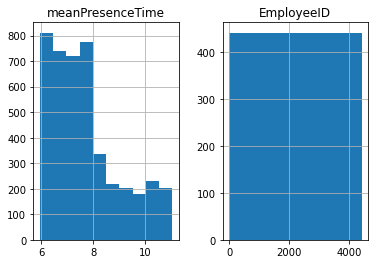

In [28]:
final_time_df.hist()

On rajoute le temps moyen effectué par les employés

In [29]:
general = general.merge(final_time_df, how='left', on='EmployeeID')

In [30]:
general

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,meanPresenceTime
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,Y,11,8,0,1.0,6,1,0,0,7.373651
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,Y,23,8,1,6.0,3,5,1,4,7.718969
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,Y,15,8,3,5.0,2,5,0,3,7.013240
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,Y,11,8,3,13.0,5,8,7,5,7.193678
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,Y,12,8,2,9.0,2,6,0,4,8.006175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,Y,17,8,1,10.0,5,3,0,2,8.522277
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,Y,15,8,0,10.0,2,3,0,2,6.092954
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,Y,20,8,0,5.0,4,4,1,2,7.706632
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,Y,14,8,1,10.0,2,9,7,8,9.492595


On calcul l'heure moyenne d'arivée et de sortie

In [31]:
in_time

,EmployeeID,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaT,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaT,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaT,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaT,2015-01-02 10:15:44,2015-01-05 10:21:05,NaT,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaT,NaT,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaT,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaT,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaT,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaT,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaT,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaT,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,4406,NaT,2015-01-02 09:20:32,2015-01-05 10:17:53,2015-01-06 10:26:51,2015-01-07 10:06:58,2015-01-08 09:45:06,2015-01-09 09:49:24,2015-01-12 09:37:10,2015-01-13 09:25:02,...,2015-12-18 10:01:06,2015-12-21 10:25:25,2015-12-22 10:16:11,2015-12-23 10:04:40,2015-12-24 09:45:40,NaT,2015-12-28 10:15:39,2015-12-29 10:10:09,2015-12-30 09:28:19,2015-12-31 10:00:12
4406,4407,NaT,2015-01-02 10:03:41,NaT,2015-01-06 09:44:00,2015-01-07 09:42:10,2015-01-08 10:00:57,2015-01-09 09:44:04,2015-01-12 10:07:32,2015-01-13 10:05:11,...,2015-12-18 09:27:32,2015-12-21 09:41:24,2015-12-22 09:50:30,2015-12-23 10:32:21,2015-12-24 09:47:41,NaT,2015-12-28 09:54:23,2015-12-29 10:13:32,2015-12-30 10:21:09,2015-12-31 10:09:48
4407,4408,NaT,2015-01-02 10:01:01,2015-01-05 09:33:00,2015-01-06 09:49:17,2015-01-07 10:28:12,2015-01-08 09:47:38,2015-01-09 10:01:03,2015-01-12 09:49:12,2015-01-13 09:47:10,...,2015-12-18 10:00:57,2015-12-21 09:51:07,2015-12-22 10:02:10,2015-12-23 09:58:29,2015-12-24 09:56:05,NaT,2015-12-28 09:59:24,NaT,2015-12-30 10:02:36,2015-12-31 10:03:30
4408,4409,NaT,2015-01-02 10:17:05,2015-01-05 10:02:27,2015-01-06 10:12:50,2015-01-07 10:12:31,2015-01-08 09:42:57,NaT,2015-01-12 10:00:38,2015-01-13 09:48:03,...,2015-12-18 09:54:33,2015-12-21 10:01:08,2015-12-22 10:10:19,2015-12-23 09:42:30,2015-12-24 09:56:05,NaT,2015-12-28 09:55:25,2015-12-29 09:54:42,2015-12-30 10:15:44,2015-12-31 09:56:47


In [32]:
def to_hour(td):
    return td.dt.hour + (td.dt.minute)/60

In [33]:
processed_in_time_df = in_time.iloc[:, 1:].apply(to_hour)
processed_out_time_df = out_time.iloc[:, 1:].apply(to_hour)

In [34]:
mean_starting_time_df = pd.DataFrame()
mean_ending_time_df = pd.DataFrame()
mean_starting_time_df["meanStartingTime"] = processed_in_time_df.mean(axis=1)
mean_ending_time_df["meanEndingTime"] = processed_out_time_df.mean(axis=1)

In [35]:
mean_starting_time_df["EmployeeID"] = out_time["EmployeeID"]
mean_ending_time_df["EmployeeID"] = out_time["EmployeeID"]

In [36]:
mean_starting_time_df

,meanStartingTime,EmployeeID
0,9.993032,1
1,9.980720,2
2,10.016598,3
3,9.973830,4
4,9.990068,5
...,...,...
4405,10.011317,4406
4406,9.996196,4407
4407,9.971501,4408
4408,10.010650,4409


In [37]:
mean_ending_time_df

,meanEndingTime,EmployeeID
0,17.367170,1
1,17.698446,2
2,17.030096,3
3,17.167305,4
4,17.996327,5
...,...,...
4405,18.533539,4406
4406,16.089281,4407
4407,17.678427,4408
4408,19.502974,4409


In [38]:
general = general.merge(mean_starting_time_df, how='left', on='EmployeeID')
general = general.merge(mean_ending_time_df, how='left', on='EmployeeID')

In [39]:
general

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,meanPresenceTime,meanStartingTime,meanEndingTime
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,8,0,1.0,6,1,0,0,7.373651,9.993032,17.367170
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,8,1,6.0,3,5,1,4,7.718969,9.980720,17.698446
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,8,3,5.0,2,5,0,3,7.013240,10.016598,17.030096
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,8,3,13.0,5,8,7,5,7.193678,9.973830,17.167305
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,8,2,9.0,2,6,0,4,8.006175,9.990068,17.996327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,8,1,10.0,5,3,0,2,8.522277,10.011317,18.533539
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,8,0,10.0,2,3,0,2,6.092954,9.996196,16.089281
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,8,0,5.0,4,4,1,2,7.706632,9.971501,17.678427
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,8,1,10.0,2,9,7,8,9.492595,10.010650,19.502974


In [40]:
in_time

,EmployeeID,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaT,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaT,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaT,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaT,2015-01-02 10:15:44,2015-01-05 10:21:05,NaT,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaT,NaT,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaT,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaT,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaT,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaT,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaT,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaT,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,4406,NaT,2015-01-02 09:20:32,2015-01-05 10:17:53,2015-01-06 10:26:51,2015-01-07 10:06:58,2015-01-08 09:45:06,2015-01-09 09:49:24,2015-01-12 09:37:10,2015-01-13 09:25:02,...,2015-12-18 10:01:06,2015-12-21 10:25:25,2015-12-22 10:16:11,2015-12-23 10:04:40,2015-12-24 09:45:40,NaT,2015-12-28 10:15:39,2015-12-29 10:10:09,2015-12-30 09:28:19,2015-12-31 10:00:12
4406,4407,NaT,2015-01-02 10:03:41,NaT,2015-01-06 09:44:00,2015-01-07 09:42:10,2015-01-08 10:00:57,2015-01-09 09:44:04,2015-01-12 10:07:32,2015-01-13 10:05:11,...,2015-12-18 09:27:32,2015-12-21 09:41:24,2015-12-22 09:50:30,2015-12-23 10:32:21,2015-12-24 09:47:41,NaT,2015-12-28 09:54:23,2015-12-29 10:13:32,2015-12-30 10:21:09,2015-12-31 10:09:48
4407,4408,NaT,2015-01-02 10:01:01,2015-01-05 09:33:00,2015-01-06 09:49:17,2015-01-07 10:28:12,2015-01-08 09:47:38,2015-01-09 10:01:03,2015-01-12 09:49:12,2015-01-13 09:47:10,...,2015-12-18 10:00:57,2015-12-21 09:51:07,2015-12-22 10:02:10,2015-12-23 09:58:29,2015-12-24 09:56:05,NaT,2015-12-28 09:59:24,NaT,2015-12-30 10:02:36,2015-12-31 10:03:30
4408,4409,NaT,2015-01-02 10:17:05,2015-01-05 10:02:27,2015-01-06 10:12:50,2015-01-07 10:12:31,2015-01-08 09:42:57,NaT,2015-01-12 10:00:38,2015-01-13 09:48:03,...,2015-12-18 09:54:33,2015-12-21 10:01:08,2015-12-22 10:10:19,2015-12-23 09:42:30,2015-12-24 09:56:05,NaT,2015-12-28 09:55:25,2015-12-29 09:54:42,2015-12-30 10:15:44,2015-12-31 09:56:47


In [41]:
sum_absence_day_df = pd.DataFrame()
sum_absence_day_df["EmployeeID"] = in_time["EmployeeID"]
sum_absence_day_df["DayOfAbsence"] = in_time.isnull().sum(axis=1)

In [42]:
sum_absence_day_df

,EmployeeID,DayOfAbsence
0,1,29
1,2,25
2,3,19
3,4,26
4,5,16
...,...,...
4405,4406,18
4406,4407,20
4407,4408,30
4408,4409,20


In [43]:
count_present_day_df = pd.DataFrame()
count_present_day_df["EmployeeID"] = in_time["EmployeeID"]
count_present_day_df["DayOfPresence"] = in_time.count(axis=1)

In [44]:
count_present_day_df

,EmployeeID,DayOfPresence
0,1,233
1,2,237
2,3,243
3,4,236
4,5,246
...,...,...
4405,4406,244
4406,4407,242
4407,4408,232
4408,4409,242


<Figure size 720x21600 with 0 Axes>

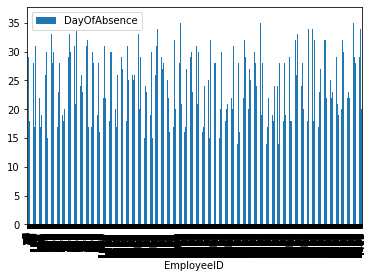

In [45]:
plt.figure(figsize=(10, 300))
sum_absence_day_df.plot(x ="EmployeeID", y = "DayOfAbsence", kind = "bar")
plt.show()

In [46]:
general = general.merge(sum_absence_day_df, how='left', on='EmployeeID')
general = general.merge(count_present_day_df, how='left', on='EmployeeID')
general

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,meanPresenceTime,meanStartingTime,meanEndingTime,DayOfAbsence,DayOfPresence
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,7.373651,9.993032,17.367170,29,233
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,7.718969,9.980720,17.698446,25,237
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,7.013240,10.016598,17.030096,19,243
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,7.193678,9.973830,17.167305,26,236
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,8.006175,9.990068,17.996327,16,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,10.0,5,3,0,2,8.522277,10.011317,18.533539,18,244
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,10.0,2,3,0,2,6.092954,9.996196,16.089281,20,242
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,5.0,4,4,1,2,7.706632,9.971501,17.678427,30,232
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,10.0,2,9,7,8,9.492595,10.010650,19.502974,20,242


## Employee survey

On va traiter le questionnaire des employés sur le vie en entreprise

In [101]:
employee_survey

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0
...,...,...,...,...
4405,4406,4.0,1.0,3.0
4406,4407,4.0,4.0,3.0
4407,4408,1.0,3.0,3.0
4408,4409,4.0,1.0,3.0


In [102]:
merged_esd = employee_survey.merge(general[['EmployeeID','Attrition']], how='left', on='EmployeeID')

In [103]:
merged_esd

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Attrition
0,1,3.0,4.0,2.0,No
1,2,3.0,2.0,4.0,Yes
2,3,2.0,2.0,1.0,No
3,4,4.0,4.0,3.0,No
4,5,4.0,1.0,3.0,No
...,...,...,...,...,...
4405,4406,4.0,1.0,3.0,No
4406,4407,4.0,4.0,3.0,No
4407,4408,1.0,3.0,3.0,No
4408,4409,4.0,1.0,3.0,No


On va ajouter au tableau la moyenne des notes de chacun des employés

In [104]:
def moyenne():
    moy = []

    for  idx, data in merged_esd.iterrows():
        nbval = 0

        if math.isnan(data['EnvironmentSatisfaction']):
            ES = 0
        else:
            nbval += 1
            ES = data['EnvironmentSatisfaction']

        if math.isnan(data['JobSatisfaction']):
            JS = 0
        else:
            nbval += 1
            JS = data['JobSatisfaction']

        if math.isnan(data['WorkLifeBalance']):
            WLB = 0
        else:
            nbval += 1
            WLB = data['WorkLifeBalance']

        if nbval != 0:
            moy.append(round(((ES + JS + WLB) / nbval), 1))
        else:
            moy.append(math.nan)
    return moy

merged_esd['Moyenne'] = pd.to_numeric(moyenne())

In [105]:
merged_esd

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Attrition,Moyenne
0,1,3.0,4.0,2.0,No,3.0
1,2,3.0,2.0,4.0,Yes,3.0
2,3,2.0,2.0,1.0,No,1.7
3,4,4.0,4.0,3.0,No,3.7
4,5,4.0,1.0,3.0,No,2.7
...,...,...,...,...,...,...
4405,4406,4.0,1.0,3.0,No,2.7
4406,4407,4.0,4.0,3.0,No,3.7
4407,4408,1.0,3.0,3.0,No,2.3
4408,4409,4.0,1.0,3.0,No,2.7


Observons la repartitions des notes de chacune des catégories

In [106]:
nb_ES = merged_esd['EnvironmentSatisfaction'].value_counts(dropna=False)
nb_ES

3.0    1350
4.0    1334
2.0     856
1.0     845
NaN      25
Name: EnvironmentSatisfaction, dtype: int64

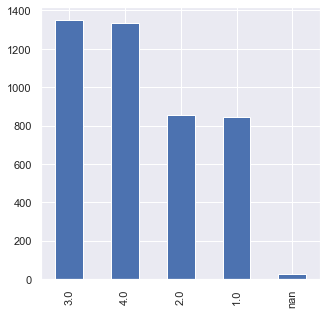

In [107]:
plt.figure(figsize=(5, 5))
nb_ES.plot(x ="note", y = "nb", kind = "bar")
plt.show()

On peut voir que la majorité des emplyés semble satisfait de l'environnement de travail cependant il y a egalement une grande quantité de très mauvaises notes.

In [108]:
nb_JS = merged_esd['JobSatisfaction'].value_counts(dropna=False)
nb_JS

4.0    1367
3.0    1323
1.0     860
2.0     840
NaN      20
Name: JobSatisfaction, dtype: int64

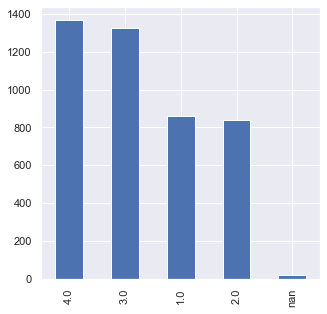

In [109]:
plt.figure(figsize=(5, 5))
nb_JS.plot(x ="note", y = "nb", kind = "bar")
plt.show()

In [110]:
nb_WLB = merged_esd['WorkLifeBalance'].value_counts(dropna=False)
nb_WLB

3.0    2660
2.0    1019
4.0     454
1.0     239
NaN      38
Name: WorkLifeBalance, dtype: int64

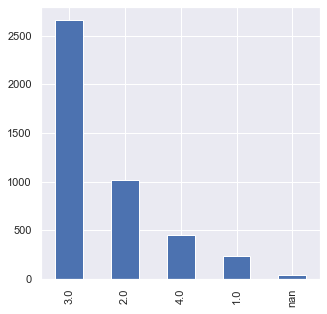

In [111]:
plt.figure(figsize=(5, 5))
nb_WLB.plot(x ="note", y = "nb", kind = "bar")
plt.show()

Ici on peut voir que la repartition est beaucoup moins homogène et meme très peu dans les extremes

In [112]:
merged_esd['Attrition'].value_counts(dropna=False)

No     3699
Yes     711
Name: Attrition, dtype: int64

## Manager survey

On va traiter le questionnaire remplit par les manager sur les employés de l'entreprise

In [113]:
manager_survey

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3
...,...,...,...
4405,4406,3,3
4406,4407,2,3
4407,4408,3,4
4408,4409,2,3


In [114]:
merged_msd = manager_survey.merge(general[['EmployeeID','Attrition']], how='left', on='EmployeeID', )

In [115]:
merged_msd

,EmployeeID,JobInvolvement,PerformanceRating,Attrition
0,1,3,3,No
1,2,2,4,Yes
2,3,3,3,No
3,4,2,3,No
4,5,3,3,No
...,...,...,...,...
4405,4406,3,3,No
4406,4407,2,3,No
4407,4408,3,4,No
4408,4409,2,3,No


### Répartition des notes "JobInvolvement"

In [116]:
nb_JI = merged_msd['JobInvolvement'].value_counts()
nb_JI

3    2604
2    1125
4     432
1     249
Name: JobInvolvement, dtype: int64

- 249 Employés ont été notés à 1
- 1125 Employés ont été notés à 2
- 2604 Employés ont été notés à 3
- 432 Employés ont été notés à 4

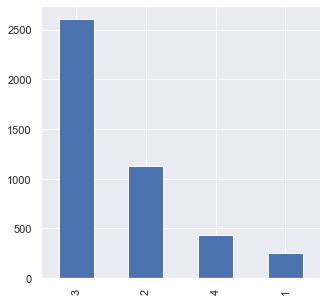

In [117]:
plt.figure(figsize=(5, 5))
nb_JI.plot(x ="note", y = "nb", kind = "bar")
plt.show()

### Répartition des notes "PerformanceRating"

In [118]:
nb_PR = merged_msd['PerformanceRating'].value_counts()
nb_PR

3    3732
4     678
Name: PerformanceRating, dtype: int64

- Aucun employés n'a été noté à 1
- Aucun employés n'a été noté à 2
- 3732 Employés ont été notés à 3
- 678 Employés ont été notés à 4

On remarque que ces valeurs ne nous permettent pas d'identifier un réel problème, étant donné que tous les employés on une note "Excellente" ou "Au dela des attentes"

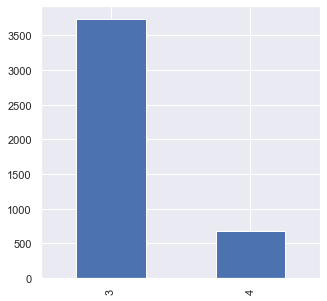

In [119]:
plt.figure(figsize=(5, 5))
nb_PR.plot(x ="note", y = "nb", kind = "bar")
plt.show()

On récupère les employés ayant un JobInvolvement inférieur à 3 (C'est à dire faible ou moyen)

In [142]:
ms_df = merged_msd.where(manager_survey["JobInvolvement"] < 3)
index_with_nan = ms_df.index[ms_df.isnull().any(axis=1)]

ms_df = ms_df.drop(['PerformanceRating'], axis=1)
ms_df.drop(index_with_nan, inplace=True)
ms_df


,EmployeeID,JobInvolvement,Attrition
1,2.0,2.0,Yes
3,4.0,2.0,No
10,11.0,2.0,No
13,14.0,2.0,Yes
16,17.0,2.0,No
...,...,...,...
4399,4400.0,2.0,No
4401,4402.0,2.0,No
4404,4405.0,2.0,No
4406,4407.0,2.0,No


Sur ces employés, seulement 234 sont parti de l'entreprise

In [144]:
ms_df["Attrition"].where(ms_df["Attrition"] == "Yes").count()

234

## Corrélation


<AxesSubplot:>

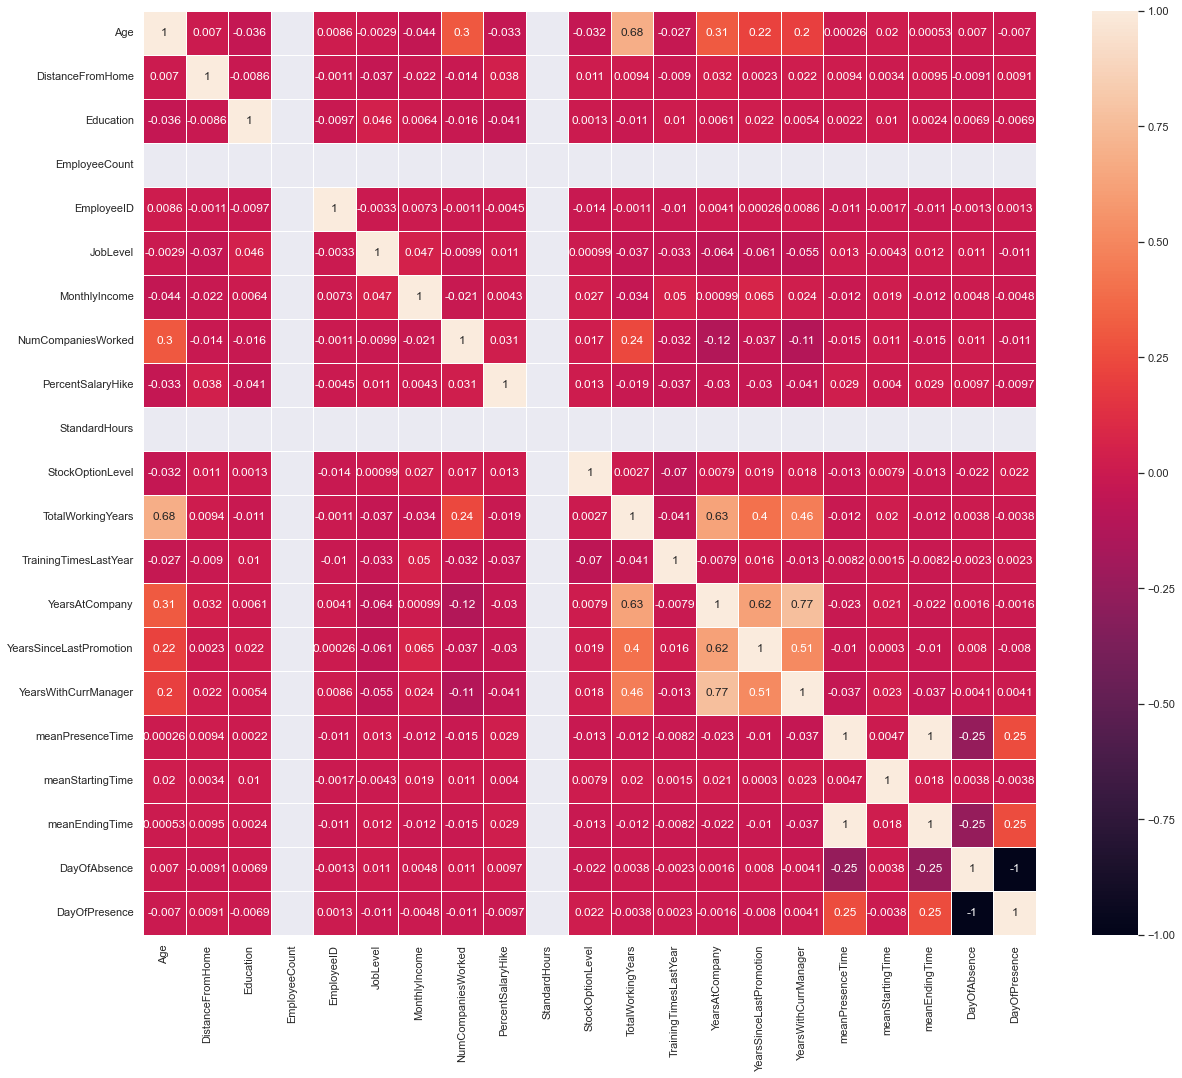

In [120]:
sns.set_theme()
f, ax = plt.subplots(figsize=(20, 17))
sns.heatmap(general.corr(), annot=True, linewidths=.5, ax=ax)

array([[<AxesSubplot:xlabel='YearsAtCompany', ylabel='YearsAtCompany'>,
        <AxesSubplot:xlabel='YearsSinceLastPromotion', ylabel='YearsAtCompany'>,
        <AxesSubplot:xlabel='YearsWithCurrManager', ylabel='YearsAtCompany'>],
       [<AxesSubplot:xlabel='YearsAtCompany', ylabel='YearsSinceLastPromotion'>,
        <AxesSubplot:xlabel='YearsSinceLastPromotion', ylabel='YearsSinceLastPromotion'>,
        <AxesSubplot:xlabel='YearsWithCurrManager', ylabel='YearsSinceLastPromotion'>],
       [<AxesSubplot:xlabel='YearsAtCompany', ylabel='YearsWithCurrManager'>,
        <AxesSubplot:xlabel='YearsSinceLastPromotion', ylabel='YearsWithCurrManager'>,
        <AxesSubplot:xlabel='YearsWithCurrManager', ylabel='YearsWithCurrManager'>]],
      dtype=object)

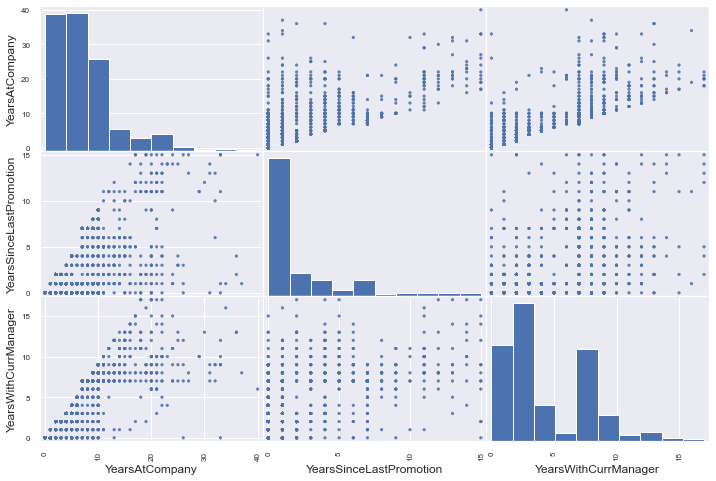

In [121]:
attributes = ["Attrition", "YearsAtCompany", "YearsSinceLastPromotion", "YearsWithCurrManager"]
scatter_matrix(general[attributes], figsize=(12, 8))

In [125]:
pre_general = general.drop(['Over18', 'Attrition', 'EmployeeCount'], axis=1)
fulldatas = pre_general.merge(merged_esd[['EmployeeID','EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Moyenne']], how='left', on='EmployeeID')
fulldatas = fulldatas.merge(merged_msd[['EmployeeID','JobInvolvement', 'PerformanceRating']], how='left', on='EmployeeID')
fulldatas = fulldatas.drop(['EmployeeID'], axis=1)
y = general['Attrition'].copy()

fulldatas

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,...,meanStartingTime,meanEndingTime,DayOfAbsence,DayOfPresence,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Moyenne,JobInvolvement,PerformanceRating
0,51,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,...,9.993032,17.367170,29,233,3.0,4.0,2.0,3.0,3,3
1,31,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,...,9.980720,17.698446,25,237,3.0,2.0,4.0,3.0,2,4
2,32,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,...,10.016598,17.030096,19,243,2.0,2.0,1.0,1.7,3,3
3,38,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,...,9.973830,17.167305,26,236,4.0,4.0,3.0,3.7,2,3
4,32,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,...,9.990068,17.996327,16,246,4.0,1.0,3.0,2.7,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,Travel_Rarely,Research & Development,5,4,Medical,Female,1,Research Scientist,Single,...,10.011317,18.533539,18,244,4.0,1.0,3.0,2.7,3,3
4406,29,Travel_Rarely,Research & Development,2,4,Medical,Male,1,Laboratory Technician,Divorced,...,9.996196,16.089281,20,242,4.0,4.0,3.0,3.7,2,3
4407,25,Travel_Rarely,Research & Development,25,2,Life Sciences,Male,2,Sales Executive,Married,...,9.971501,17.678427,30,232,1.0,3.0,3.0,2.3,3,4
4408,42,Travel_Rarely,Sales,18,2,Medical,Male,1,Laboratory Technician,Divorced,...,10.010650,19.502974,20,242,4.0,1.0,3.0,2.7,2,3


## Pipeline

In [126]:
#general_num = general.select_dtypes(include=[np.number])
#merged_esd_num = merged_esd.select_dtypes(include=[np.number])
fulldatas_num = fulldatas.select_dtypes(include=[np.number])
cat_attribs = ["BusinessTravel", "Department", "EducationField", "Gender", "JobRole", "MaritalStatus"]

#num_attribs = list(merged_esd_num)
num_attribs = list(fulldatas_num)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

#merged_esd_prepared = full_pipeline.fit_transform(merged_esd)
fulldatas_prepared = full_pipeline.fit_transform(fulldatas)

In [127]:
fulldatas_prepared

array([[ 1.54136892, -0.39393818, -0.89168825, ...,  0.        ,
         1.        ,  0.        ],
       [-0.64866811,  0.09963874, -1.86842575, ...,  0.        ,
         0.        ,  1.        ],
       [-0.53916626,  0.96339837,  1.06178675, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.30567922,  1.95055222, -0.89168825, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.55585225,  1.0867926 , -0.89168825, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.33684855,  2.32073492,  0.08504925, ...,  1.        ,
         0.        ,  0.        ]])

In [128]:
X_train, X_test, y_train, y_test = fulldatas_prepared[:3000,:], fulldatas_prepared[3000:,:], y[:3000], y[3000:]

In [129]:
y_train

0        No
1       Yes
2        No
3        No
4        No
       ... 
2995     No
2996     No
2997     No
2998     No
2999    Yes
Name: Attrition, Length: 3000, dtype: object

In [130]:
shuffle_index = np.random.permutation(3000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## SGBD Classifier

In [131]:
y_train_stay = (y_train == 'Yes')
y_test_stay = (y_test == 'Yes')

Pour commencer, nous allons entraîner un classifieur par descente de gradient stochastique en utilisant le SGDClassifier de scikit-learn. Cet algorithme a pour principal atout de traiter chaque instance indépendamment, il est donc particulièrement adapté pour l’apprentissage online. Créons-le et entraînons-le sur le jeu d’entraînement.

In [132]:
sgd_clf = SGDClassifier(max_iter=100)
sgd_clf.fit(X_train, y_train_stay)

SGDClassifier(max_iter=100)

In [133]:
sgd_clf.predict([fulldatas_prepared[1501]])

array([False])

In [134]:
y.iloc[1501]

'No'

On vois bien qu'il est resté (True) et que son attrition est également à Non



In [135]:
forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_stay, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_stay,y_scores_forest)

On va voir la matrice de confusion

In [136]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_stay, cv=3)
matrix = confusion_matrix(y_train_stay, y_train_pred)
matrix

array([[2292,  226],
       [ 317,  165]], dtype=int64)

Precision score

In [137]:
precision_score(y_train_stay, y_train_pred)

0.4219948849104859

Recall Score

In [138]:
recall_score(y_train_stay, y_train_pred)

0.34232365145228216

In [139]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_stay, cv=3, method="decision_function")

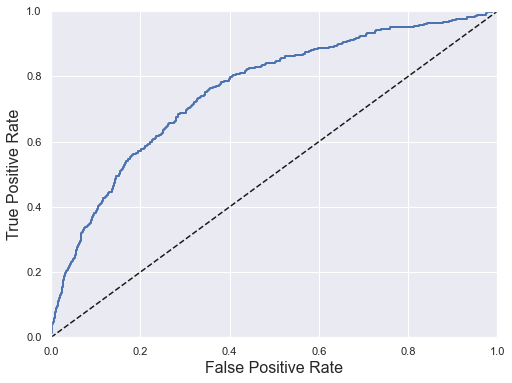

In [141]:
fpr, tpr, thresholds = roc_curve(y_train_stay, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()